## Small Utility Scripts to Visualize Data

In [67]:
%matplotlib notebook
import numpy as np
import pandas as pd
import shelve
import os

from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler

from objects import Conditions, Data, Prediction, MachineChar, EndMill
from ml import UnifiedLinearModel, mean_no_outliers
from optimize import Optimizer
from collections import defaultdict
from itertools import combinations

from IPython.core.display import display, HTML
def niceprint(*args):
    display(HTML("<p>" + " ".join([str(i) for i in args]) + "</p>"))
    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120), 
     (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150), 
     (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148), 
     (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199), 
     (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)] 
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau20)): 
    r, g, b = tableau20[i] 
    tableau20[i] = (r / 255., g / 255., b / 255.) 

def get_params(desired_data):
    model = UnifiedLinearModel()
    model.ingest_data(desired_data)
    return model.params
    
# sweep graphs'
def sweep_graphs(desired_data):
    model = UnifiedLinearModel()
    # # alternate training scheme
    # with shelve.open(os.path.join("saved_cuts", "db")) as db:
    #     model.ingest_data(db["ammp-alu-3_8"])
    model.ingest_data(desired_data)

    predictions = model.predict([datum.conditions() for datum in desired_data])

    def form_dataframe_data(data):
        a = list()
        for datum in data:
            D, W, f_r, w, endmill, Ts, Fys = datum.unpack()
            a.append([D, W, f_r, w, endmill, mean_no_outliers(Ts[:, 1]), mean_no_outliers(Fys[:, 1])])
        return pd.DataFrame(a, columns = ['D', 'W', 'f_r','w', 'endmill', 'Ts', 'Fys'])

    def form_dataframe_predictions(predictions):
        return pd.DataFrame([prediction.unpack() for prediction in predictions], columns = ['D', 'W', 'f_r','w', 'endmill', 'T', 'F'])
    
    niceprint("<h3>Sweep Graphs</h3>")
    df = form_dataframe_data(desired_data)
    dfp = form_dataframe_predictions(predictions)
    feeds = df.f_r.unique()
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    axs = [ax1, ax2]
    for i, feed in enumerate(reversed(feeds)):
        is_desired = df['f_r'] == feed
        axs[0].set_title("Torque predicted vs. actual")
        axs[0].set(xlabel = "WOC (m)", ylabel = "Torque (Nm)")
        axs[0].plot(df[is_desired]['W'], df[is_desired]['Ts'], label="Actual, feed " + "{:.3f} m/s".format(feed), linestyle='--', color = tableau20[i % 20])
        axs[0].plot(dfp[is_desired]['W'], dfp[is_desired]['T'], label="Pred., feed " + "{:.3f} m/s".format(feed), color = tableau20[i % 20])
        axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        fig1.savefig('generated_assets/sweep_graphs/' + data_name + '_torques.png', dpi = 300, bbox_inches = 'tight')
        axs[1].set_title("Force predicted vs. actual")
        axs[1].set(xlabel = "WOC (m)", ylabel = "Force (N)")
        axs[1].plot(df[is_desired]['W'], df[is_desired]['Fys'], label="Actual, feed " + "{:.3f} m/s".format(feed), linestyle='--', color = tableau20[i % 20])
        axs[1].plot(dfp[is_desired]['W'], [a[1] for a in dfp[is_desired]['F']], label="Pred., feed " + "{:.3f} m/s".format(feed), color = tableau20[i % 20])
        axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        fig2.savefig('generated_assets/sweep_graphs/' + data_name + '_forces.png', dpi = 300, bbox_inches = 'tight')


    # find average error
    errors_T = list()
    errors_Fy = list()
    for datum, prediction in zip(desired_data, predictions):
        datum_T = mean_no_outliers(datum.Ts[:, 1])
        datum_Fy = mean_no_outliers(datum.Fys[:, 1])
        errors_T.append((datum_T - prediction.T) / prediction.T)
        errors_Fy.append((datum_Fy - prediction.F[1]) / prediction.F[1])
        
    niceprint("Params:", model.params)
    niceprint("R<sup>2</sup> value:", model.score())
    niceprint("Average error for T:", np.mean(np.abs(errors_T)))
    niceprint("Average error for Fy:", np.mean(np.abs(errors_Fy)))
    
# analyze ammp runs
def ammp_graphs(data, data_name, USE_OLD_RUN = False):
    full_name = data_name
    model = UnifiedLinearModel()
    if USE_OLD_RUN:
        with shelve.open(os.path.join("saved_cuts", "db")) as db:
            model.ingest_data(db[USE_OLD_RUN])
            full_name += '_using_' + USE_OLD_RUN

    actual_T = [mean_no_outliers(i.Ts[:, 1]) for i in data]
    actual_Fy = [mean_no_outliers(i.Fys[:, 1]) for i in data]
    pred_T = []
    pred_Fy = []

    for datum in data:
        pred = model.predict_one(datum.conditions())
        pred_T.append(pred.T)
        pred_Fy.append(pred.F[1])
        model.ingest_datum(datum)

    niceprint("<h3>AMMP Graphs for", data_name, "</h3>")
    # fig, ax = plt.subplots(2)
    fig, ax = plt.subplots(2)
    ax[0].set_title("Torques w/ all Data")
    ax[0].set_xlabel("Cut Number")
    ax[0].set_ylabel("Torque (Nm)")
    ax[0].plot(range(len(data)), actual_T, label = "Actual", linestyle='--', color = tableau20[0])
    ax[0].plot(range(len(data)), [model.predict_one(d.conditions()).T for d in data], label = "Predicted", color = tableau20[4])
    ax[0].legend()
    ax[0].label_outer()
    ax[1].set_title("Forces w/ all Data")
    ax[1].set_xlabel("Cut Number")
    ax[1].set_ylabel("Force (N)")
    ax[1].plot(range(len(data)), actual_Fy, label = "Actual", linestyle='--', color = tableau20[0])
    ax[1].plot(range(len(data)), [model.predict_one(d.conditions()).F[1] for d in data], label = "Predicted", color = tableau20[4])
    plt.savefig('generated_assets/ammp_graphs/' + full_name + '_all_data.png', dpi = 300, bbox_inches = 'tight')

    fig, ax = plt.subplots(2)
    ax[0].set_title("Torques w/ Sequential Data")
    ax[0].set_xlabel("Cut Number")
    ax[0].set_ylabel("Torque (Nm)")
    ax[0].plot(range(len(data)), actual_T, label = "Actual", linestyle='--', color = tableau20[0])
    ax[0].plot(range(len(data)), pred_T, label = "Predicted", color = tableau20[4])
    ax[0].legend()
    ax[0].label_outer()
    ax[1].set_title("Forces w/ Sequential Data")
    ax[1].set_xlabel("Cut Number")
    ax[1].set_ylabel("Force (N)")
    ax[1].plot(range(len(data)), actual_Fy, label = "Actual", linestyle='--', color = tableau20[0])
    ax[1].plot(range(len(data)), pred_Fy, label = "Predicted", color = tableau20[4])
    plt.savefig('generated_assets/ammp_graphs/' + full_name + '_seq_data.png', dpi = 300, bbox_inches = 'tight')

    errors_T = list()
    errors_Fy = list()
    for datum, prediction in zip(data, model.predict([d.conditions() for d in data])):
        datum_T = mean_no_outliers(datum.Ts[:, 1])
        datum_Fy = mean_no_outliers(datum.Fys[:, 1])
        errors_T.append((datum_T - prediction.T) / prediction.T)
        errors_Fy.append((datum_Fy - prediction.F[1]) / prediction.F[1])

    niceprint("Model params:", model.params)
    niceprint("R<sup>2</sup> value:", model.score())
    niceprint("Average error for T:", np.mean(np.abs(errors_T)))
    niceprint("Average error for Fy:", np.mean(np.abs(errors_Fy)))
    
def data_graphs(data):
    plt.figure()
    for i, datum in enumerate(data):
        plt.title("Torques")
        plt.plot(datum.Ts[:, 0], datum.Ts[:, 1], color = tableau20[i % 20])

    plt.figure()

    for i, datum in enumerate(data):
        plt.title("Forces")
        plt.plot(datum.Fys[:, 0], datum.Fys[:, 1], color = tableau20[i % 20])

    for i, datum in enumerate(data):
        niceprint(i, datum)

In [ ]:
# get data
data_name = 'ammp-brass-1_8'
data = None
with shelve.open(os.path.join("saved_cuts", "shelve")) as db:
    niceprint("<br>".join(list(db.keys())))
    data = db[data_name]

<IPython.core.display.Javascript object>


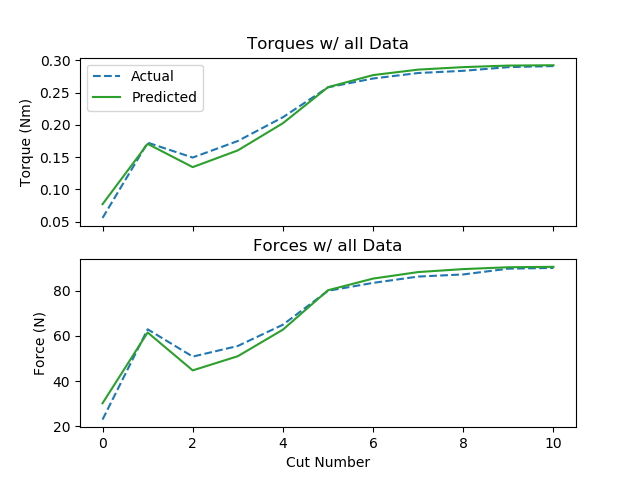

<IPython.core.display.Javascript object>


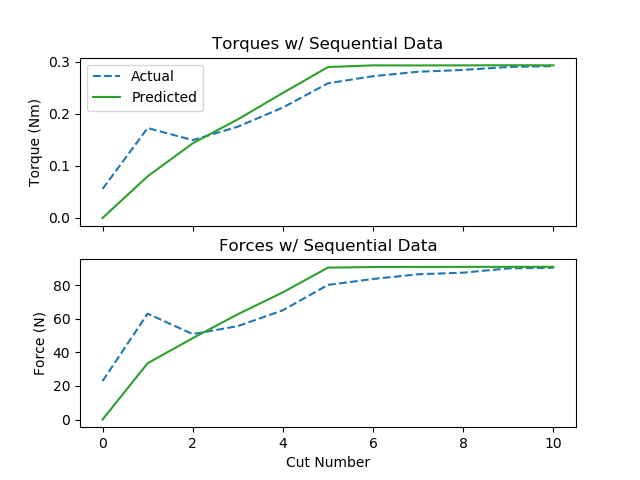

<IPython.core.display.Javascript object>


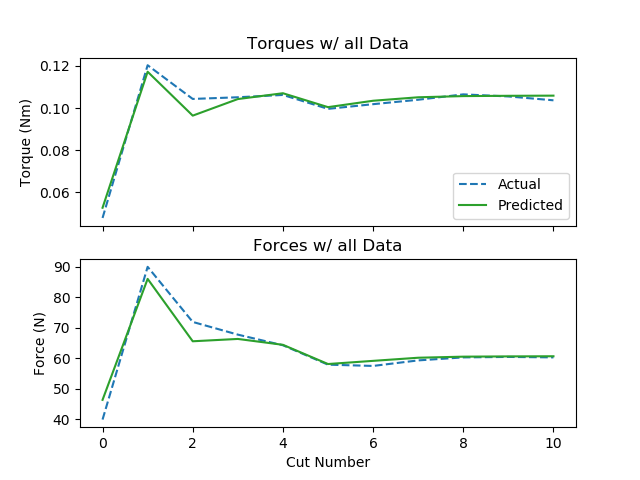

<IPython.core.display.Javascript object>


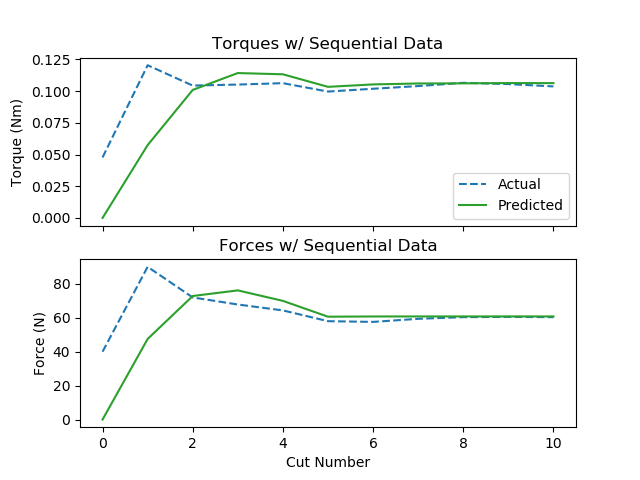

<IPython.core.display.Javascript object>


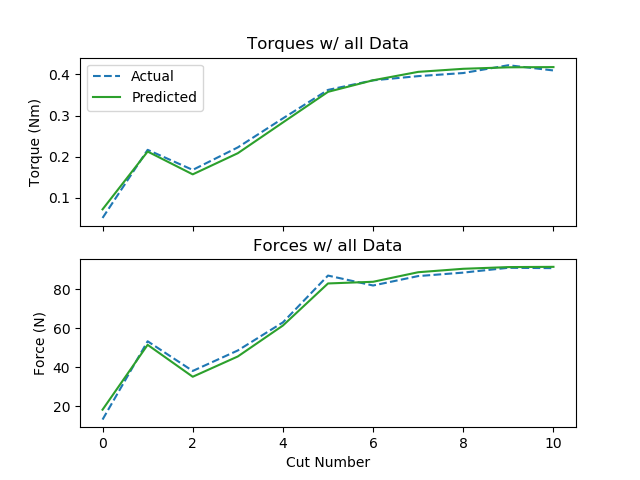

<IPython.core.display.Javascript object>


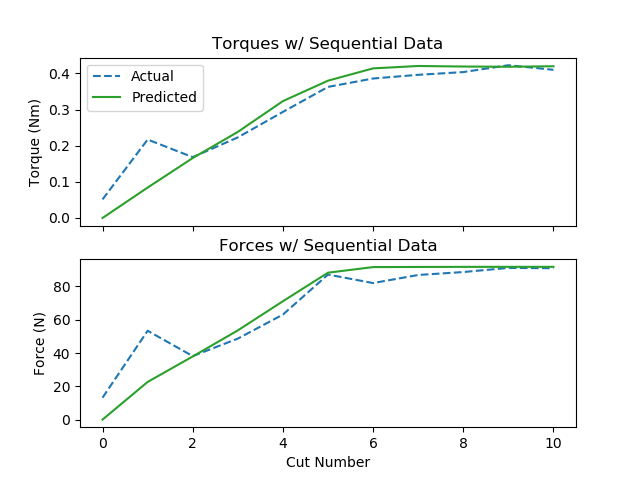

<IPython.core.display.Javascript object>


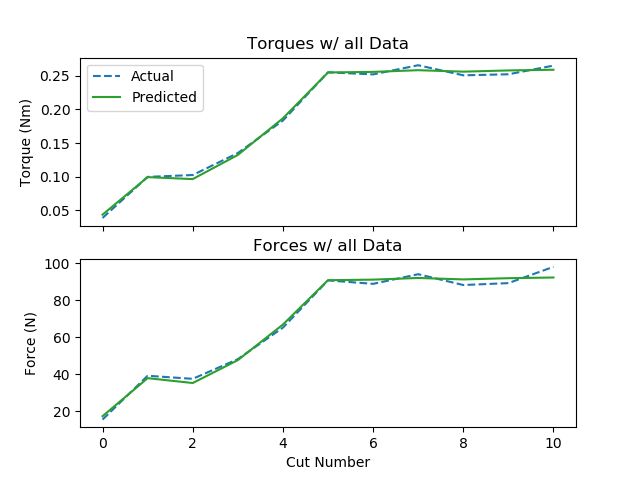

<IPython.core.display.Javascript object>


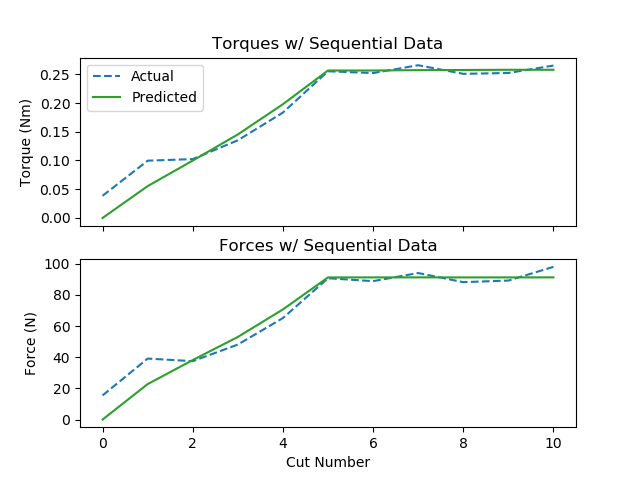

<IPython.core.display.Javascript object>


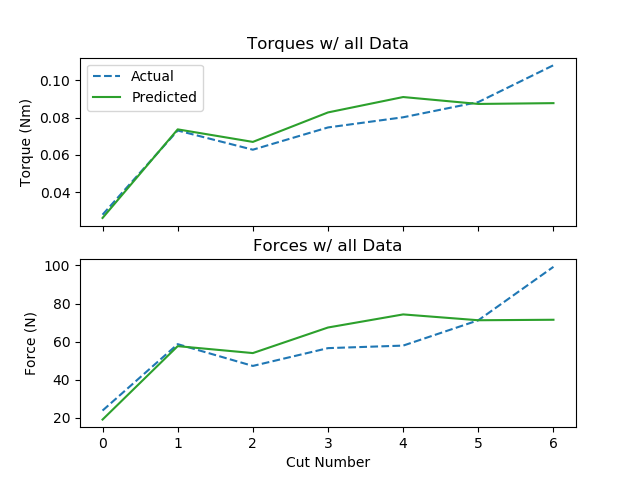

<IPython.core.display.Javascript object>


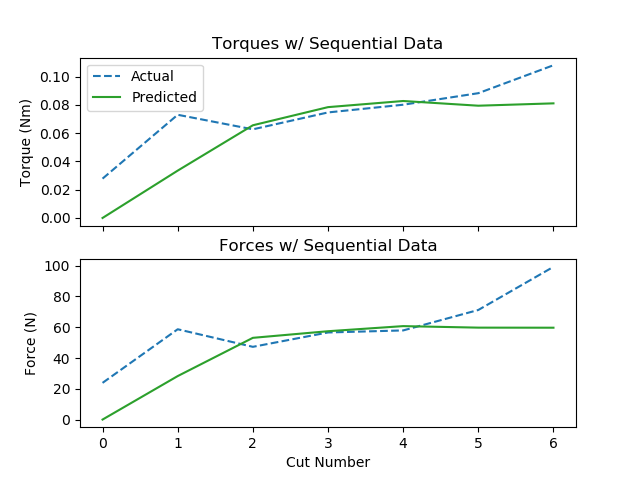

<IPython.core.display.Javascript object>


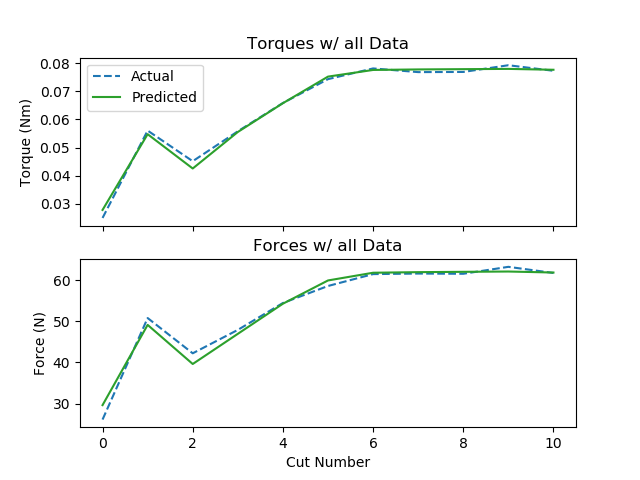

<IPython.core.display.Javascript object>


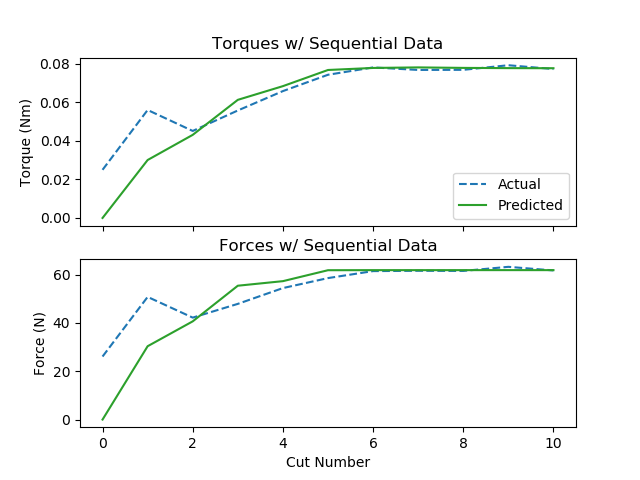

<IPython.core.display.Javascript object>


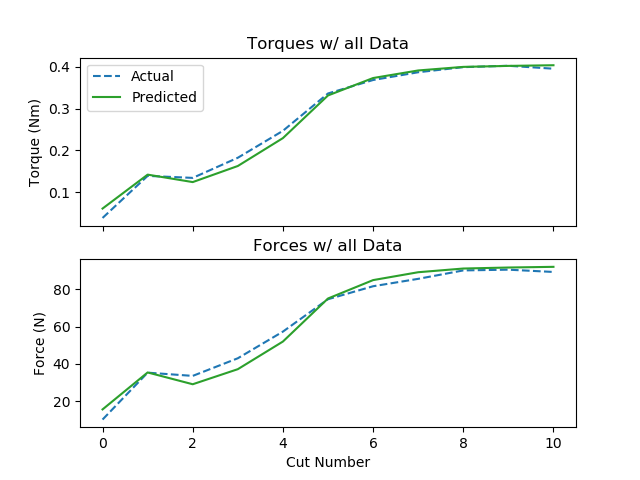

<IPython.core.display.Javascript object>


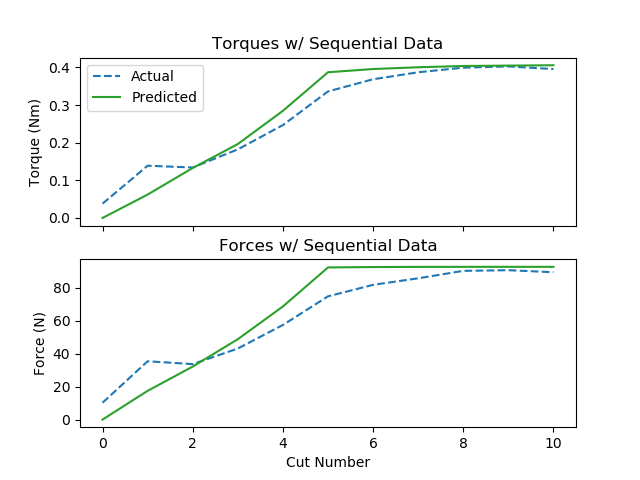

<IPython.core.display.Javascript object>


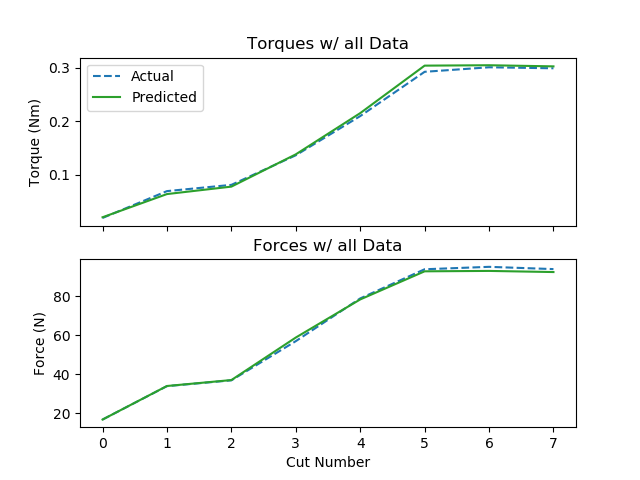

<IPython.core.display.Javascript object>


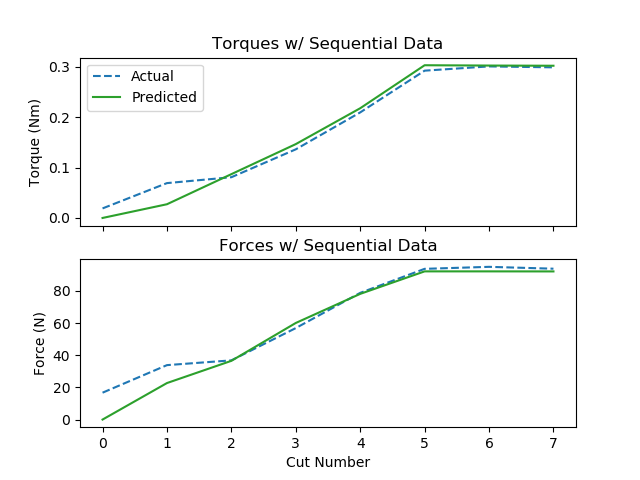

<IPython.core.display.Javascript object>


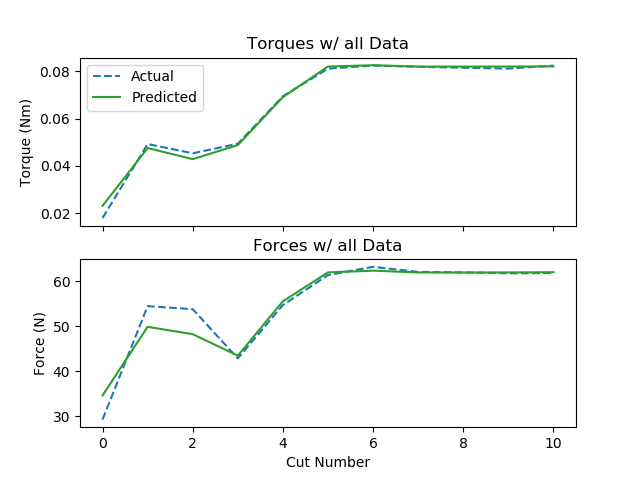

<IPython.core.display.Javascript object>


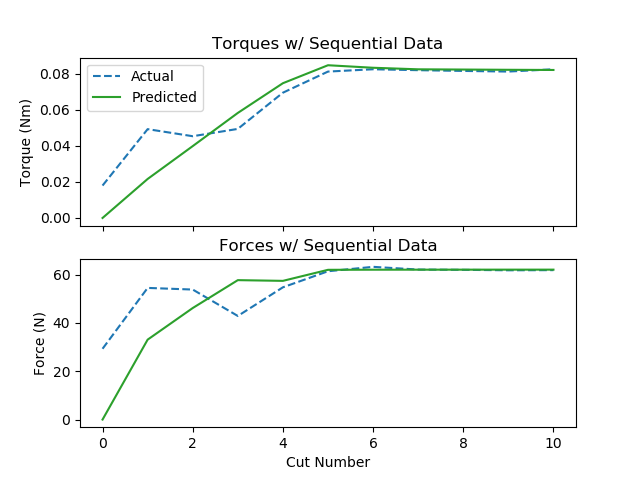

<IPython.core.display.Javascript object>


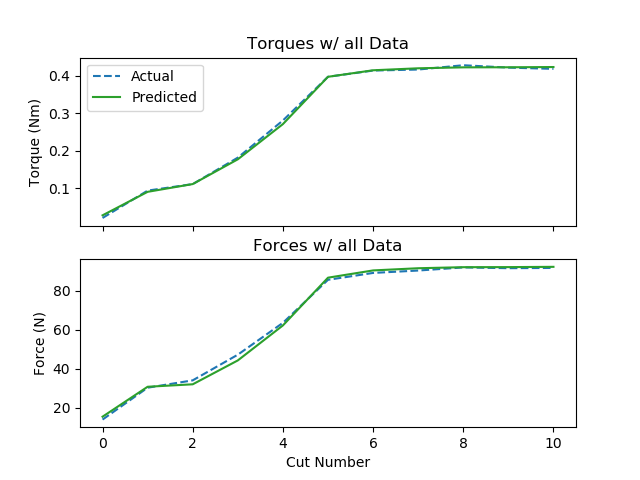

<IPython.core.display.Javascript object>


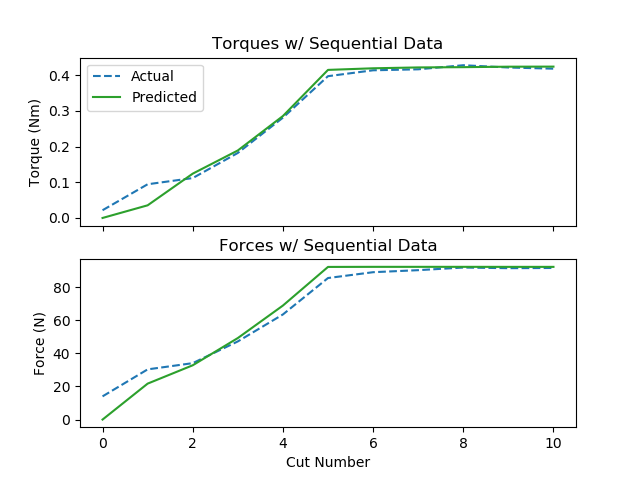

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


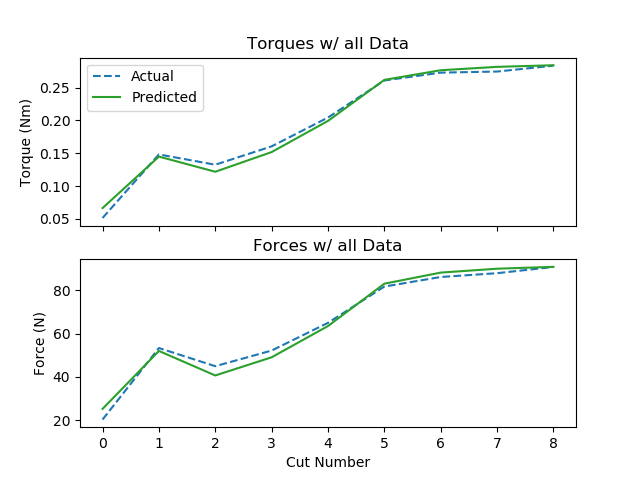

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


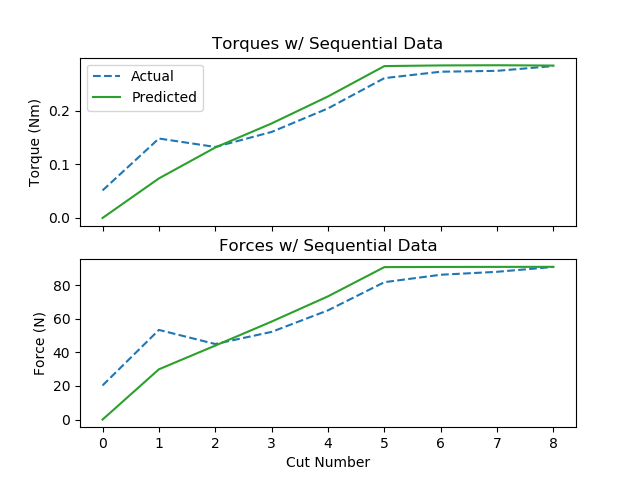

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


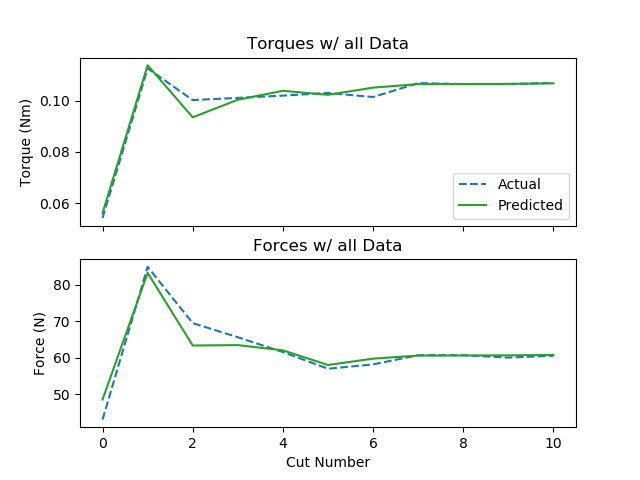

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


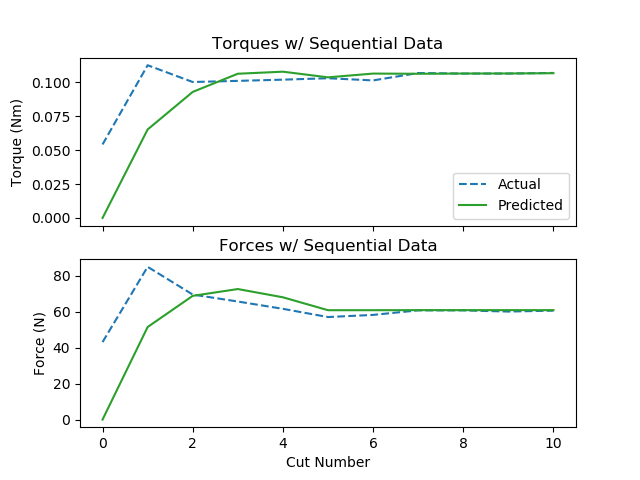

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


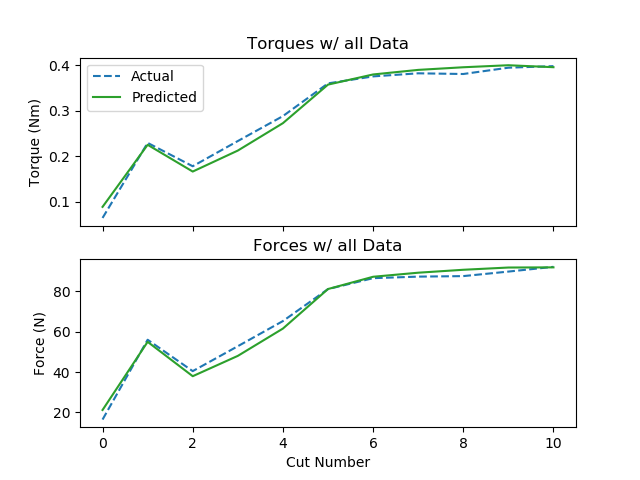

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


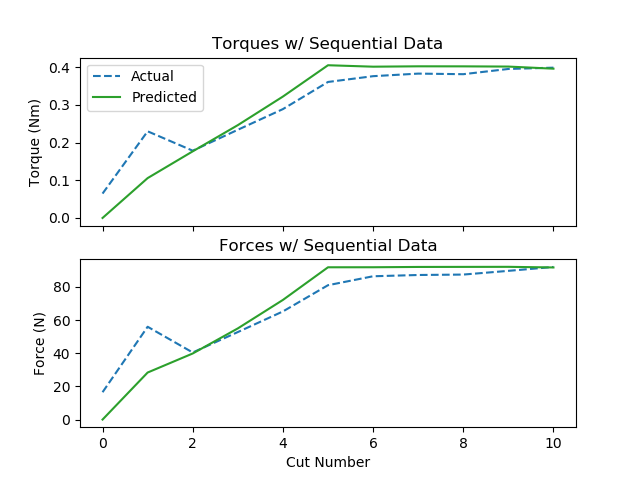

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


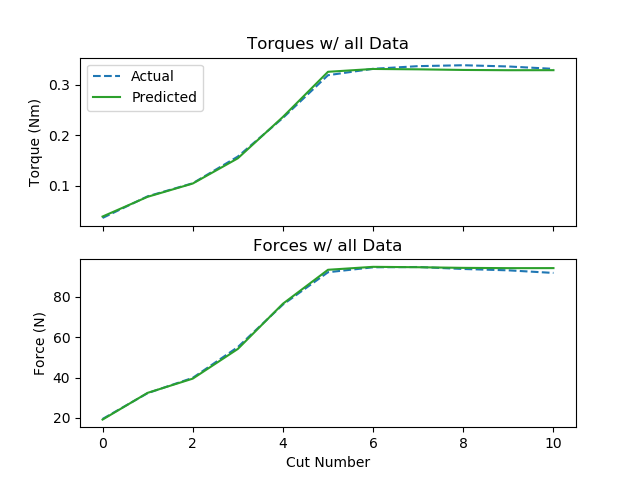

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


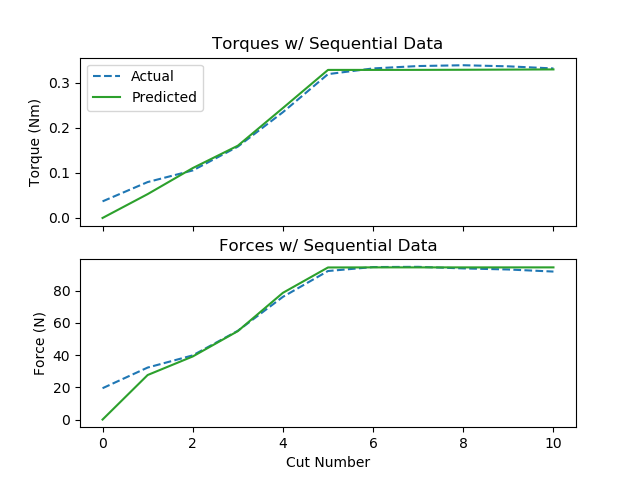

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


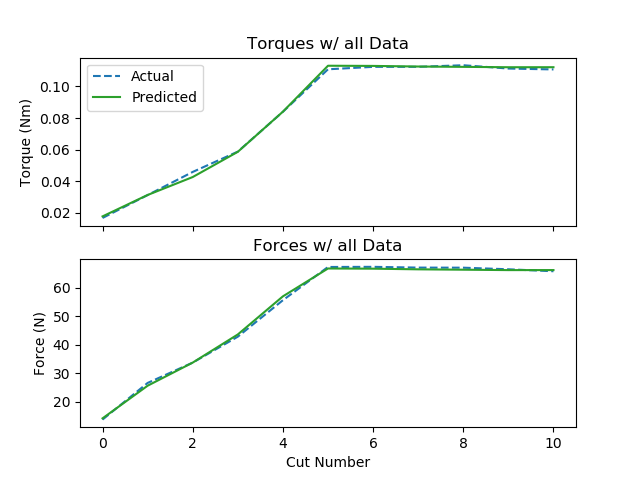

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


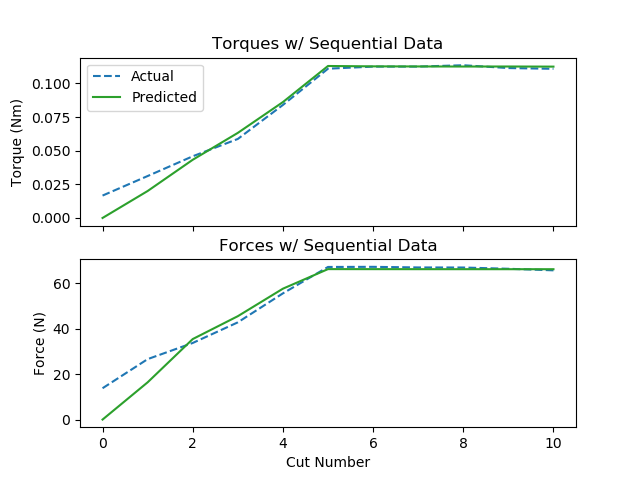

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


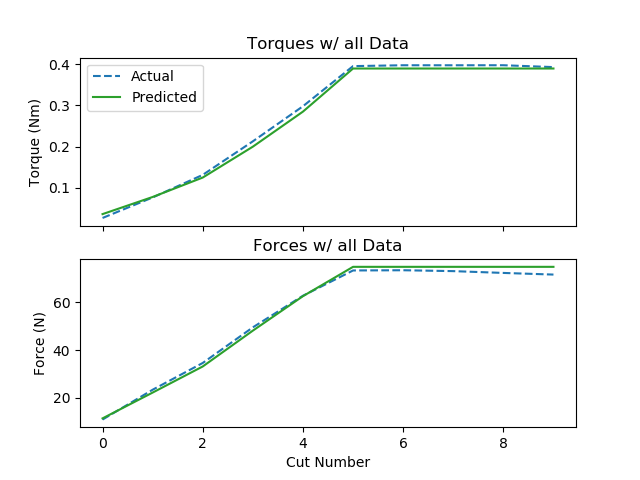

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


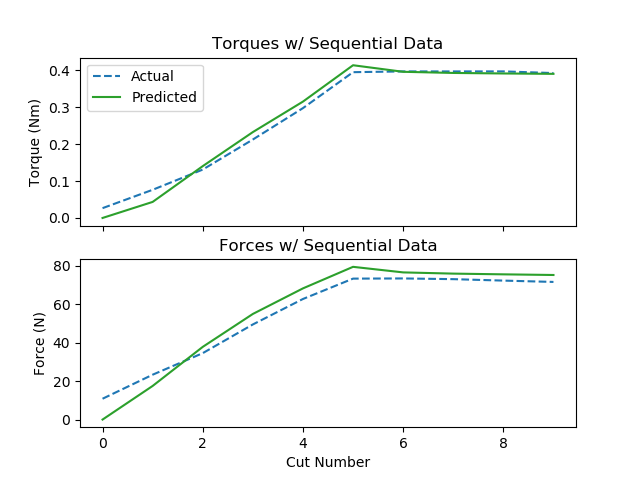

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


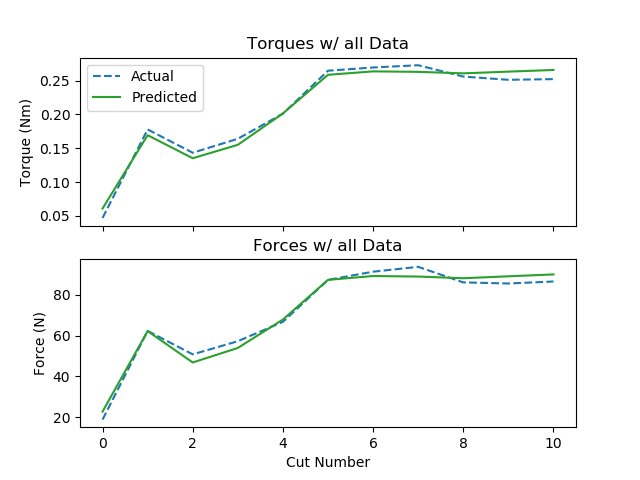

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


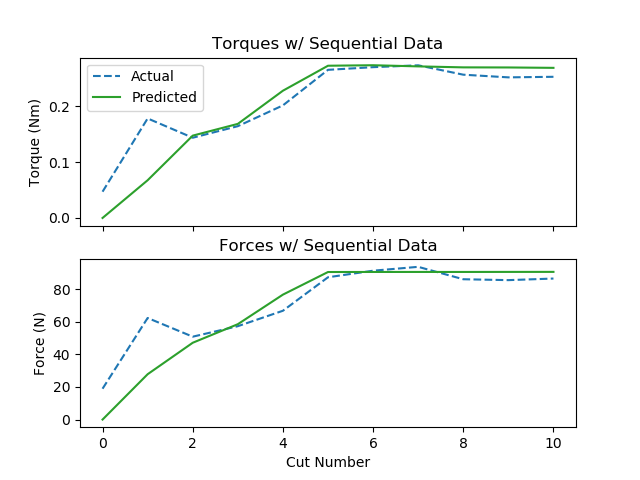

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


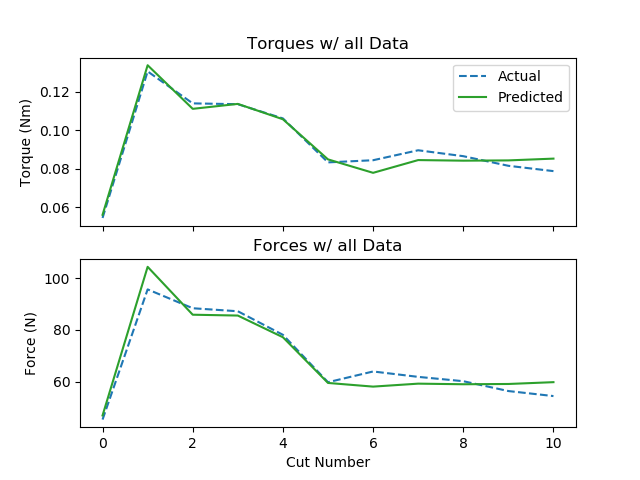

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


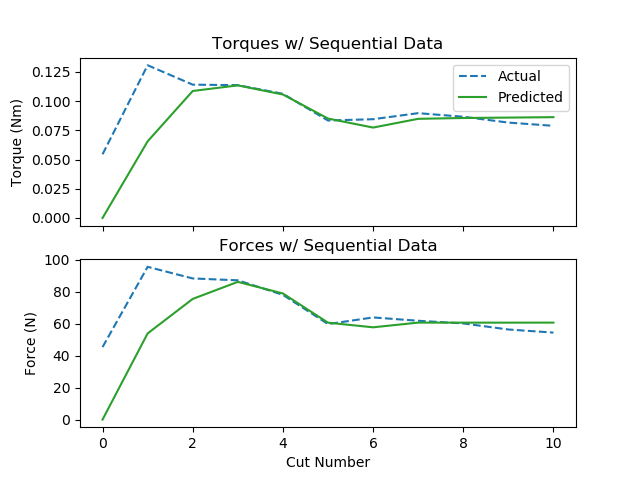

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


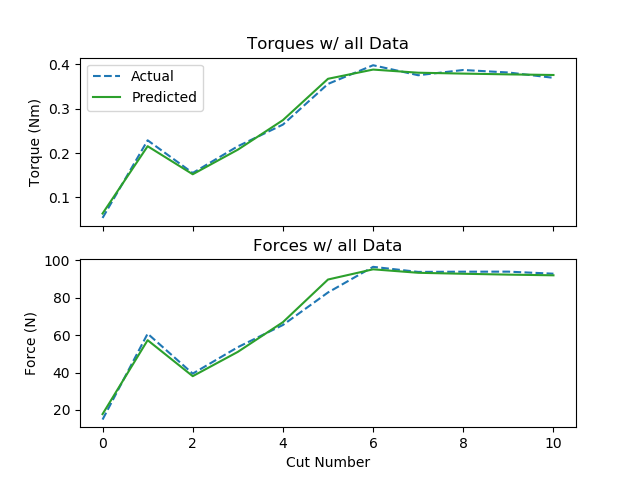

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


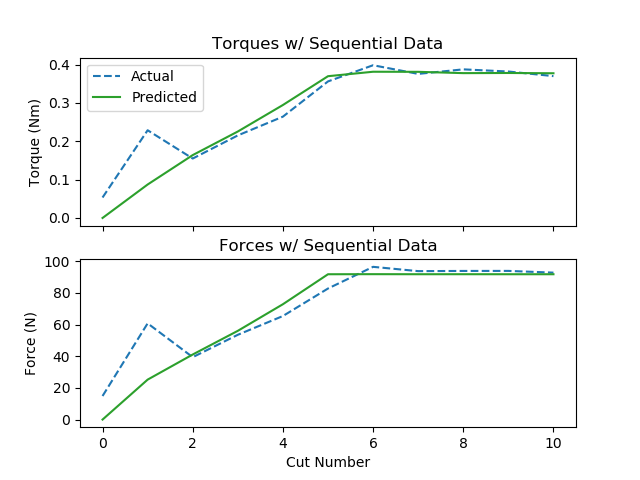

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


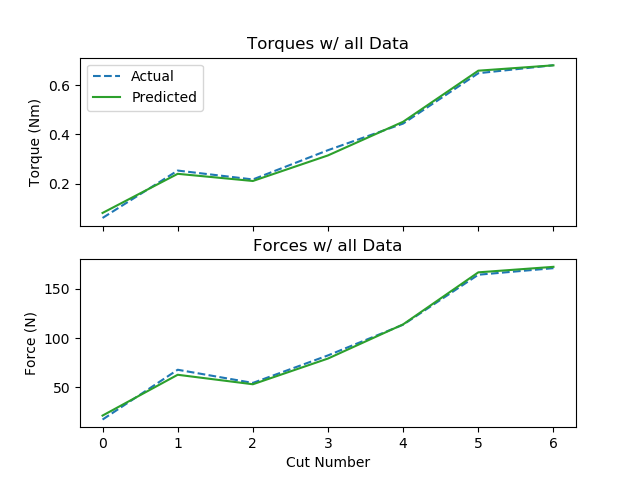

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


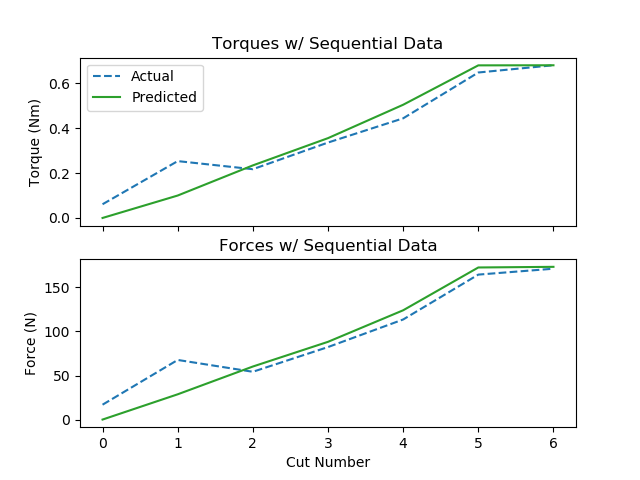

<ipython-input-1-ab06f946ba61>:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


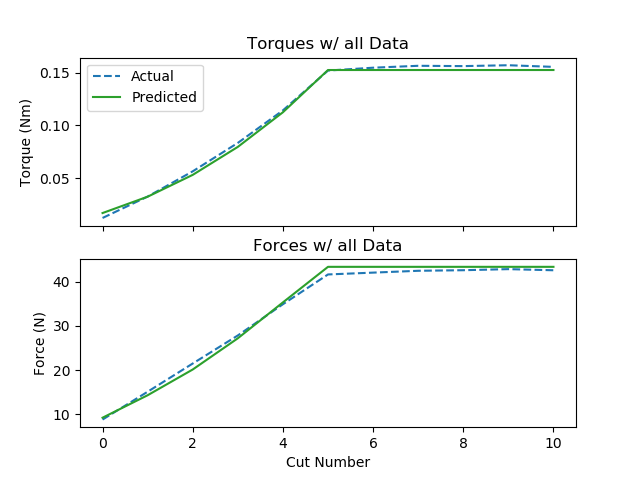

<ipython-input-1-ab06f946ba61>:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2)


<IPython.core.display.Javascript object>


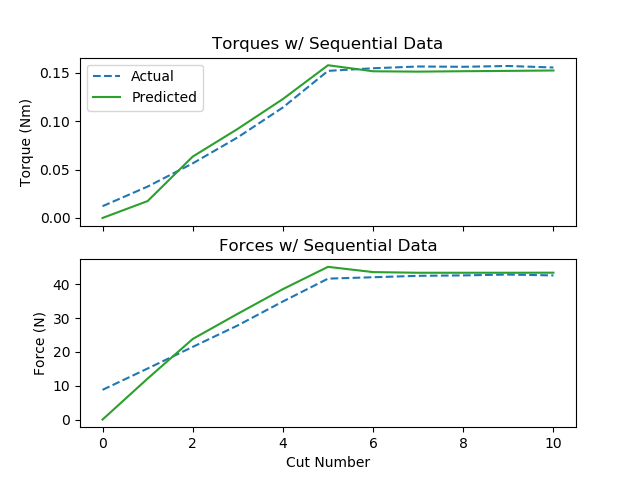

In [3]:
with shelve.open(os.path.join("saved_cuts", "shelve")) as db:
    for data_name in sorted(db.keys()):
        if "sweep" not in data_name:
            data = db[data_name]
            ammp_graphs(data, data_name)

In [71]:
# mini experiment to see how well a linear regressor can predict the cutting force coefficients
blacklist = ['ammp-alu-1_8_coolant', 'ammp-ss-3_8-no_deflection_limit', 'ammp-alu-1_8', 'sweep-alu-1_4']
with shelve.open(os.path.join("saved_cuts", "shelve")) as db:
    materials = defaultdict(list)
    for key in db.keys():
        if key in blacklist: continue
        _, material, _ = key.split("-", 2)
        data = db[key]
        materials[material] += data
    
    
material_params = {material: get_params(data) for material, data in materials.items()}    
# all material properties are in SI units with no prefixes
material_props = {
    'alu': {
        'ultimate_tensile_strength': 310e6,
        'tensile_yield_strength': 275e6,
        'elastic_modulus': 68.9e9,
        'elongation_at_break': 0.17,
        'specific_heat_capacity': 896,
        'thermal_conductivity': 167,
        'solidus': 582
    },
    'lcs': {
        'ultimate_tensile_strength': 440e6,
        'tensile_yield_strength': 370e6,
        'elastic_modulus': 200e9,
        'elongation_at_break': 0.15,
        'specific_heat_capacity': 486,
        'thermal_conductivity': 51.9,
        'solidus': 1420,
    },
    'brass': {
        'ultimate_tensile_strength': 400e6,
        'tensile_yield_strength': 310e6,
        'elastic_modulus': 97e9,
        'elongation_at_break': 0.25,
        'specific_heat_capacity': 380,
        'thermal_conductivity': 115,
        'solidus': 885,
    },
    '4140': {
        'ultimate_tensile_strength': 655e6,
        'tensile_yield_strength': 415e6,
        'elastic_modulus': 205e9,
        'elongation_at_break': 0.25,
        'specific_heat_capacity': 473,
        'thermal_conductivity': 42.6,
        'solidus': 1420,
    },
    'pc': {
        'ultimate_tensile_strength': 66.2e6,
        'tensile_yield_strength': 63.3e6,
        'elastic_modulus': 2.36e9,
        'elongation_at_break': 0.87,
        'specific_heat_capacity': 1540,
        'thermal_conductivity': 0.196,
        'solidus': 146,
    },
    'ss': {
        'ultimate_tensile_strength': 515e6,
        'tensile_yield_strength': 205e6,
        'elastic_modulus': 193e9,
        'elongation_at_break': 0.40,
        'specific_heat_capacity': 500,
        'thermal_conductivity': 16.2,
        'solidus': 1400,
    },
    'uhmw': {
        'ultimate_tensile_strength': 44.1e6,
        'tensile_yield_strength': 23.4e6,
        'elastic_modulus': 1.21e9,
        'elongation_at_break': 3.50,
        'specific_heat_capacity': 1900,
        'thermal_conductivity': 0.410,
        'solidus': 136,
    }
}

# arrange into vectors
materials = sorted(list(material_params.keys()))
properties = sorted(list(material_props['alu'].keys()))

props_to_vector = lambda props: [i[1] for i in sorted([(key, item) for key, item in props.items()])]

def average_error(y_ests, y_acts):
    errors = list()
    for i in range(len(y_ests)):
        y_est, y_act = y_ests[i], y_acts[i]
        y_diff = [abs((a - b) / a) for a, b in zip(y_est, y_act)]
        errors.append(np.mean(y_diff))
    return np.mean(errors)

for num in range(2, 7):
    best_score, best_combination = float('inf'), None
    property_combinations = combinations(properties, num)
    for property_combination in property_combinations:
        x_vector = np.array([[material_props[material][prop] for prop in property_combination] for material in materials])
        y_vector = np.array([material_params[material] for material in materials])
        input_scaler, output_scaler = StandardScaler(), StandardScaler()
        input_scaler.fit(x_vector)
        output_scaler.fit(y_vector)

        x_vector_scaled = input_scaler.transform(x_vector)
        y_vector_scaled = output_scaler.transform(y_vector)
        
        scores = list()
        
        # aggressive leave-one-out testing
        
        for i in range(len(x_vector_scaled)):
            x_missing_one = [x_vector_scaled[j] for j in range(len(x_vector_scaled)) if j != i]
            y_missing_one = [y_vector_scaled[j] for j in range(len(y_vector_scaled)) if j != i]
            model = LinearRegression()
            model.fit(x_missing_one, y_missing_one)
            y_pred = output_scaler.inverse_transform(model.predict([x_vector_scaled[i]]))
            y_act = output_scaler.inverse_transform([y_vector_scaled[i]])
            score = average_error(y_pred, y_act)
            scores.append(score)
        
        score = np.mean(scores)
        
        if score < best_score:
            best_score = score
            best_combination = property_combination
            
    niceprint("Best properties to use when only using", num, "of them:", ", ".join(best_combination), "with score", best_score)

In [ ]:
# generate demo videos
for i in range(0, len(data)):
    fig, ax = plt.subplots(2)
    ax[0].set_title("Torques w/ Sequential Data")
    ax[0].set_xlabel("Cut Number")
    ax[0].set_ylabel("Torque (Nm)")
    ax[0].plot(range(len(data)), actual_T, label = "Actual", linestyle='--')
    ax[0].plot(range(i + 1), pred_T[:1 + i], label = "Predicted")
    ax[0].legend()
    ax[0].label_outer()
    ax[1].set_title("Forces w/ Sequential Data")
    ax[1].set_xlabel("Cut Number")
    ax[1].set_ylabel("Force (N)")
    ax[1].plot(range(len(data)), actual_Fy, label = "Actual", linestyle='--')
    ax[1].plot(range(i + 1), pred_Fy[:1 + i], label = "Predicted")
    plt.savefig('generated_assets/frames/' + data_name + '_frame_' + str(i) + '.png', dpi = 300)
    plt.close(fig)